# Model Building, Scoring & Evaluating (Logistic Regression)

In [20]:
# Imports
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F

from snowflake.ml.modeling.linear_model import LogisticRegression
from snowflake.ml.modeling.metrics import *

import json
import pandas as pd
import seaborn as sns

In [21]:
# Create Snowpark Session
with open('creds.json') as f:
    connection_parameters = json.load(f)

session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "CC_DB"."PUBLIC"
Current Warehouse: "CC_WH"


### Model Building

In [23]:
application_record_balanced_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED')
application_record_balanced_sdf.group_by('TARGET').count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|0         |29819    |
|1         |29819    |
----------------------



In [11]:
# Using stratified sampling of the data. 
# Using sample_by allows us to sample based on one column and also specify the fractions of each value in the column.

train_sdf = application_record_balanced_sdf.sample_by("TARGET", {1: 0.8, 0: 0.8})
train_sdf = train_sdf.cache_result()
train_sdf.group_by('TARGET').count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|1         |24001    |
|0         |23860    |
----------------------



In [24]:
# The test data set is the rest of the rows, by using minus we can exclude the rows from the train_sdf DataFrame

test_sdf = application_record_balanced_sdf.minus(train_sdf)
test_sdf.group_by('TARGET').count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|0         |5959     |
|1         |4759     |
----------------------



In [ ]:
# Save the training and test data into tables

train_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN', mode='overwrite')
test_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TEST', mode='overwrite')

In [25]:
train_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN')
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')

In [ ]:
# Fitting a LogisticRegression model using snowpark-ml
feature_cols = train_sdf.columns
feature_cols.remove('TARGET')
feature_cols.remove('ID')
target_col = 'TARGET'

lm = LogisticRegression(
    C=0.8, 
    solver='lbfgs',
    random_state=0, 
    input_cols=feature_cols, 
    label_cols=target_col, 
    output_cols=['PREDICTION']
    )

In [15]:
# Fit the LogisticRegression model
!pip uninstall lightgbm -y
lm.fit(train_sdf)

Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0


Package 'snowflake-telemetry-python' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.
The version of package 'xgboost' in the local environment is 3.0.0, which does not fit the criteria for the requirement 'xgboost==2.1.1'. Your UDF might not work when the package version is different between the server and your local environment.
/Users/navisha/anaconda3/lib/python3.11/site-packages/snowflake/ml/model/model_signature.py:82: UserWarning: The sample input has 47861 rows, thus a truncation happened before inferring signature. This might cause inaccurate signature inference. If that happens, consider specifying signature manually.
  warnings.warn(
/Users/navisha/anaconda3/lib/python3.11/site-packages/snowflake/ml/model/model_signature.py:82: UserWarning: The sample input has 47861 rows, thus a truncation happened before inferring signature. This might cause inaccurate signature inference. If t

In [ ]:
# The fitted model can be retrieved as a scikit-learn object
lm_local = lm.to_sklearn()
lm_local

LogisticRegression(C=0.8, random_state=0)

<Axes: >

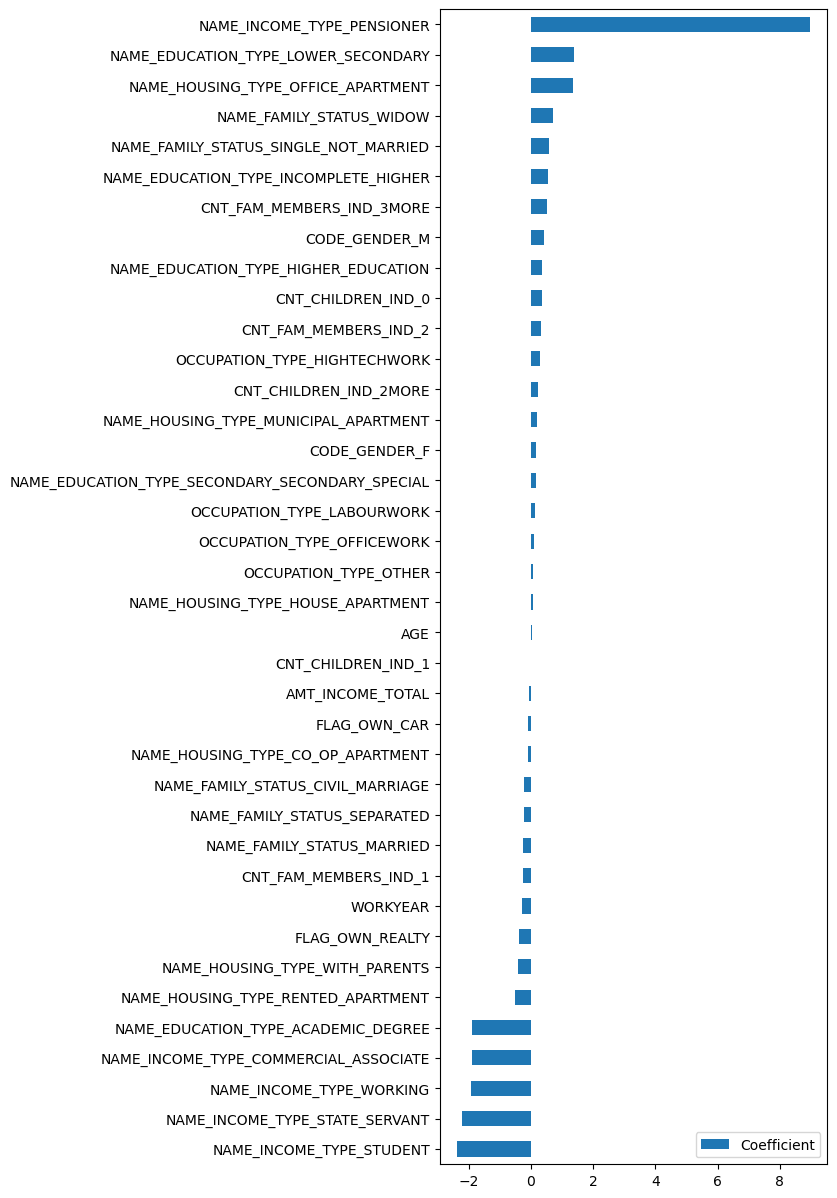

In [17]:
# Plotting Feature Coefficients

feature_coefficients = pd.DataFrame(lm_local.coef_.T,lm_local.feature_names_in_,columns=['Coefficient'])
feature_coefficients.sort_values('Coefficient').plot.barh(y='Coefficient', figsize=(5,15))

### Model Scoring

Using the predict method of the snowpark-ml model will push down the scoring into Snowflake, it can be applied on a Snowpark DataFrame or a Pandas DataFrame

In [ ]:
scored_snowml_sdf = lm.predict(test_sdf)

In [26]:
scored_snowml_sdf = lm.predict(test_sdf)
# Saving it as a table so we do not call the predict function when using the scored DataFrame
scored_snowml_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED', mode='overwrite')

### Model Evaluation

In [28]:
scored_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED')

<Axes: >

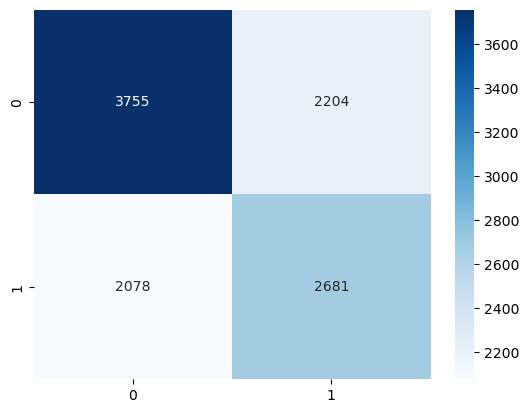

In [29]:
# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=scored_sdf, y_true_col_name='TARGET', y_pred_col_name='PREDICTION')

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

In [30]:
# Calculating and printing the accuracy, precision, recall, and F1 score
print('Acccuracy:', accuracy_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('Precision:', precision_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('Recall:', recall_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('F1:', f1_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))

Acccuracy: 0.600485
Precision: 0.5488229273285568


DataFrame.flatten() is deprecated since 0.7.0. Use `DataFrame.join_table_function()` instead.


Recall: 0.5633536457238916
F1: 0.5559933637494814


In [31]:
session.close()